# Part 07
----
이번 파트에서는 선형회귀분석을 행한다. 전체 선형회귀분석 외에도 이전 파트에서 시계열 클러스터링을 이용하여 구분한 행정구역들을 별개로 회귀분석을 시행하였다.

In [1]:
%matplotlib inline
import sklearn.preprocessing
import sklearn.feature_selection
from sklearn.decomposition import PCA

In [2]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + '06_pop_estate_ts_year.csv', encoding='utf-8')

In [3]:
# changing the column order
df_columns = ['year', 'area_code', 'label', 'trade_vol',
              'mov_vol', 'head_ratio', 'head_male_ratio', 'head_age', 'mov_multi_ratio', 'ppl_per_house',
              'mov_ppl_vol', 'mov_male_ratio', 'pop_change_ratio', 'built',
              'r_1', u'r_2', 'r_3', 'r_5', 'r_4', 'r_6', 'r_9',
              'ppa_median', 'ppa_mean', 'ppa_median_log']

df = df_original[df_columns]

In [4]:
df.head()

,year,area_code,label,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,mov_multi_ratio,ppl_per_house,...,r_1,r_2,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log
0,2006,11170,1.0,2415.0,83396.0,0.791513,0.630687,40.849627,0.349069,1.704194,...,0.049918,-0.013934,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776
1,2006,11215,1.0,2658.0,125386.0,0.794283,0.649972,38.791690,0.380864,1.801972,...,-0.043442,0.011524,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613
2,2006,11230,1.0,3690.0,118019.0,0.781713,0.658541,40.292758,0.351901,1.726120,...,0.003838,-0.012532,0.000373,-0.000441,0.003991,-0.001246,-0.006550,319.865320,325.644840,5.767900
3,2006,11290,1.0,4833.0,141745.0,0.781079,0.663439,40.920615,0.406406,1.854104,...,0.014667,-0.007104,0.017214,-0.000049,0.001206,-0.000967,-0.002667,305.250305,319.570049,5.721132
4,2006,11320,1.0,6653.0,101650.0,0.762440,0.670976,41.877358,0.437973,1.938898,...,0.009828,-0.008205,-0.011225,-0.000777,-0.001299,-0.001121,-0.008942,230.038340,252.419874,5.438246


In [5]:
# reshaping the dataframe for easier use
df = df.astype({'label': int})

In [6]:
df = df.set_index(['label', 'area_code'])

In [7]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log']

In [8]:
# custom class that contains three dataframes according to respective labels
class Cases_df:
    def __init__(self, df, target='ppa_median_log', do_pca=False, do_f_reg=False):
        self.all = Custom_df(df.reset_index(0), target, do_pca, do_f_reg)
        self.one = Custom_df(df.loc[0], target, do_pca, do_f_reg)
        self.two = Custom_df(df.loc[1], target, do_pca, do_f_reg)

In [9]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df, target, do_pca, do_f_reg):
        # create a scaler for a given dataframe
        self.dfX = df.drop(ppa_columns, axis=1)
        self.dfy = df[ppa_columns]
        
        self.df_scaler = Scaler(self.dfX)
        
        # create a normalized copy
        self.dfX = pd.DataFrame(self.df_scaler.X.transform(self.dfX), index=self.dfX.index, columns=self.dfX.columns)
        
        # patching things up
        if 0 in self.dfX.index:
            self.dfX = self.dfX.reset_index(0)
            self.dfy = self.dfy.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.dfX, self.dfy, target, do_pca, do_f_reg)
        
        self.area_codes = df.index.unique()

In [10]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, dfX):
        self.X = sk.preprocessing.StandardScaler()
        self.X.fit(dfX)

In [11]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than threshold)
# then throws out variables that aren't statistically significant (also greater than threshold)
def optimize_fit(dfX, dfy, target, do_pca=False, do_f_reg=False):
    # threshold to pass for the variables to keep
    threshold = 0.01
    
    # perform PCA
    if do_pca:
        pca = PCA()
        pca.fit(dfX)
        feature_size = pca.explained_variance_ratio_[~(pca.explained_variance_ratio_.cumsum() >= (1 - threshold))].size
        pca = PCA(n_components=feature_size)
        pca.fit(dfX)
        dfX = pd.DataFrame(pca.fit_transform(dfX), index=dfX.index)    
    
    dfX = sm.add_constant(dfX)
    
    # perform F-regression
    if do_f_reg:
        F, F_p = sk.feature_selection.f_regression(dfX, dfy[target])
        f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
        dfX = dfX.drop(f_reg.loc[f_reg.F_p > threshold].index, axis=1)
    
    # drop statistically not significant variables one by one
    while True:
        model = sm.OLS(dfy[target], dfX)
        result = model.fit()
        not_significant = result.pvalues[result.pvalues > threshold]
        
        if not_significant.size == 0:
            break
        else:
            dfX = dfX.drop(not_significant.sort_values().index[0], axis=1)

    return dfX, dfy, result

In [12]:
# custom plotting function
def plot_results(df_custom, target):
    # plot predicted price vs actual price
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(df_custom.result.predict(df_custom.dfX), df_custom.dfy[target], c=df_custom.dfy.index, cmap='prism')
    plt.xlabel('Predicted ' + target)
    plt.ylabel('Actual ' + target)
    
    plt.subplot(1, 2, 2)
    sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy[target])
    plt.xlabel('Price difference distribution of ' + target)
    
    if target[-3:] == 'log':
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(np.exp(df_custom.result.predict(df_custom.dfX)),
                    np.exp(df_custom.dfy[target]),
                    c=df_custom.dfy.index, cmap='prism')    
        plt.xlabel('Predicted ' + target[-3:])
        plt.ylabel('Actual ' + target[-3:])
        
        plt.subplot(1, 2, 2)
        sns.distplot(np.exp(df_custom.result.predict(df_custom.dfX)) - np.exp(df_custom.dfy[target]))
        plt.xlabel('Price difference distribution of ' + target[-3:])

In [13]:
target = 'ppa_median_log'
do_pca = False
do_f_reg = True

In [14]:
# create a custom object with all pertaining info
df_cases = Cases_df(df, target, do_pca=False, do_f_reg=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     441.5
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:28:19   Log-Likelihood:                -21.358
No. Observations:                1210   AIC:                             66.72
Df Residuals:                    1198   BIC:                             127.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.3823      0.007    7

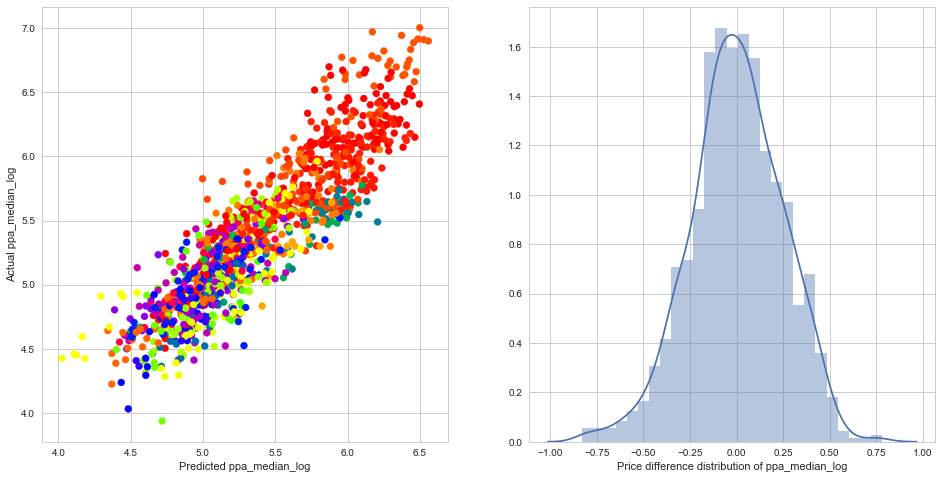

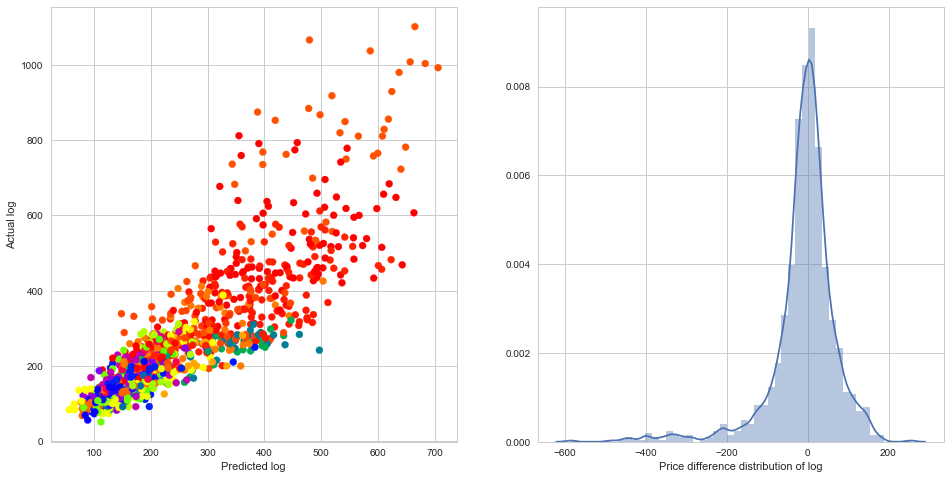

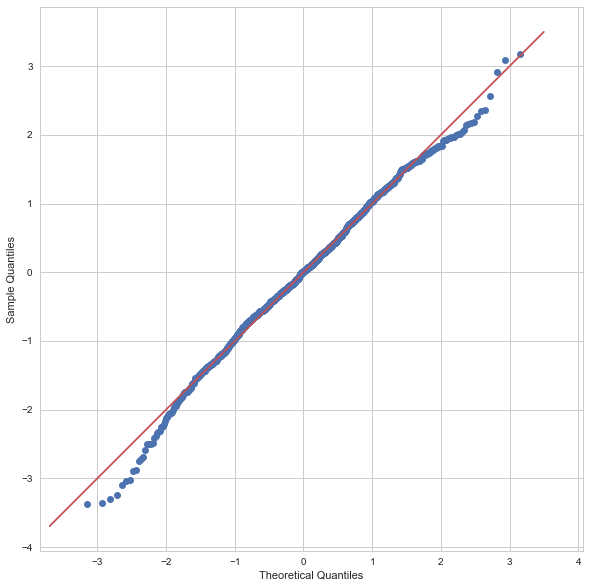

In [15]:
# print the fitted result for all area codes
print(df_cases.all.result.summary())
plot_results(df_cases.all, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.all.result.predict(df_cases.all.dfX) - df_cases.all.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     266.5
Date:                Fri, 21 Jul 2017   Prob (F-statistic):          1.08e-229
Time:                        19:28:20   Log-Likelihood:                 233.48
No. Observations:                 780   AIC:                            -447.0
Df Residuals:                     770   BIC:                            -400.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0881      0.006    787.112

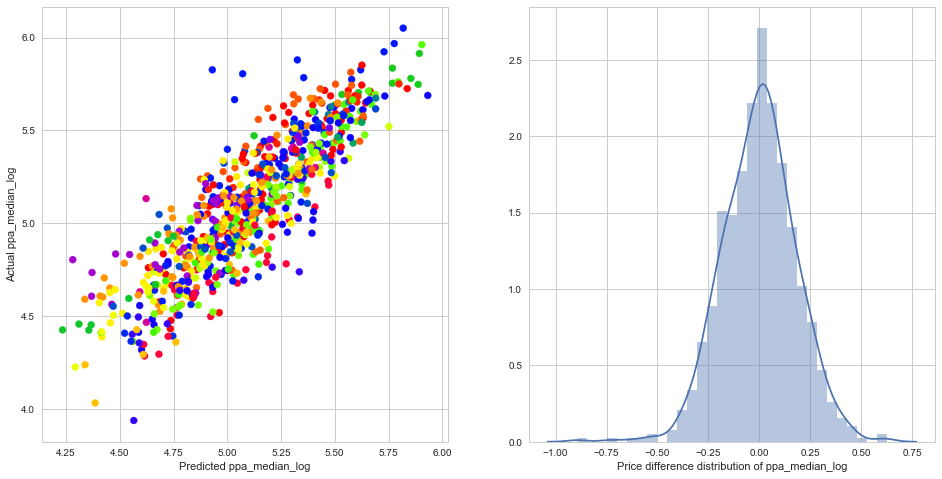

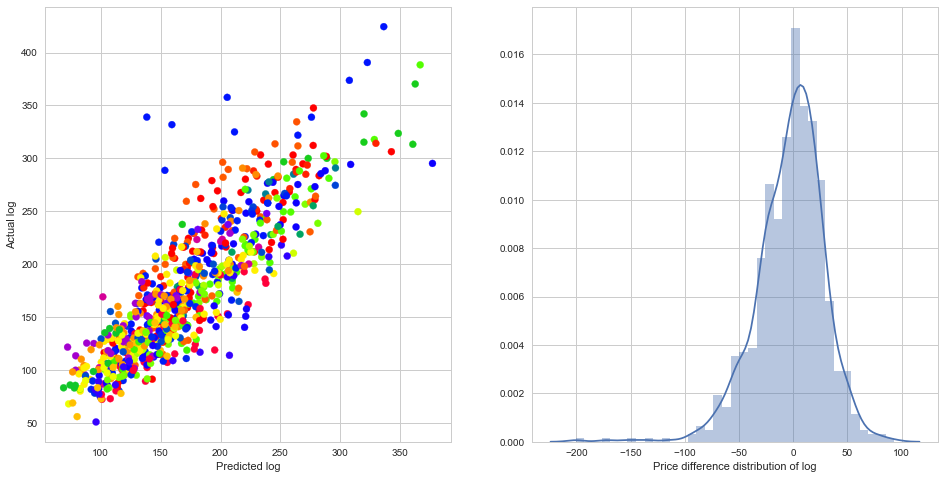

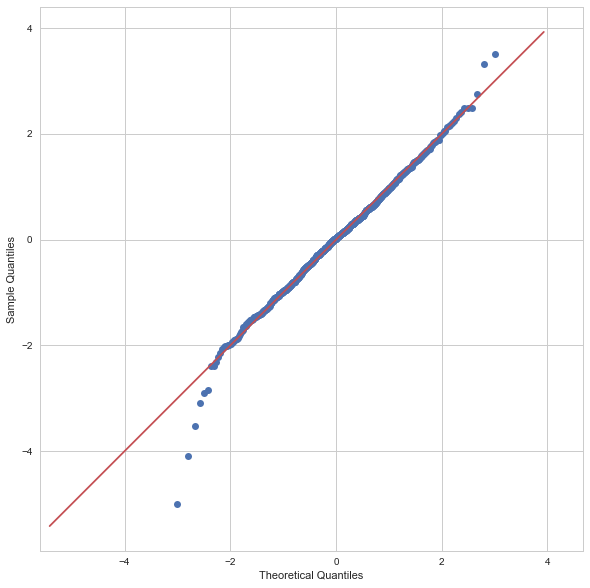

In [16]:
# print the fitted result for all area codes with label 0
print(df_cases.one.result.summary())
plot_results(df_cases.one, target)

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.one.result.predict(df_cases.one.dfX) - df_cases.one.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     147.6
Date:                Fri, 21 Jul 2017   Prob (F-statistic):          4.26e-117
Time:                        19:28:21   Log-Likelihood:                 45.351
No. Observations:                 430   AIC:                            -72.70
Df Residuals:                     421   BIC:                            -36.13
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.9161      0.011    5

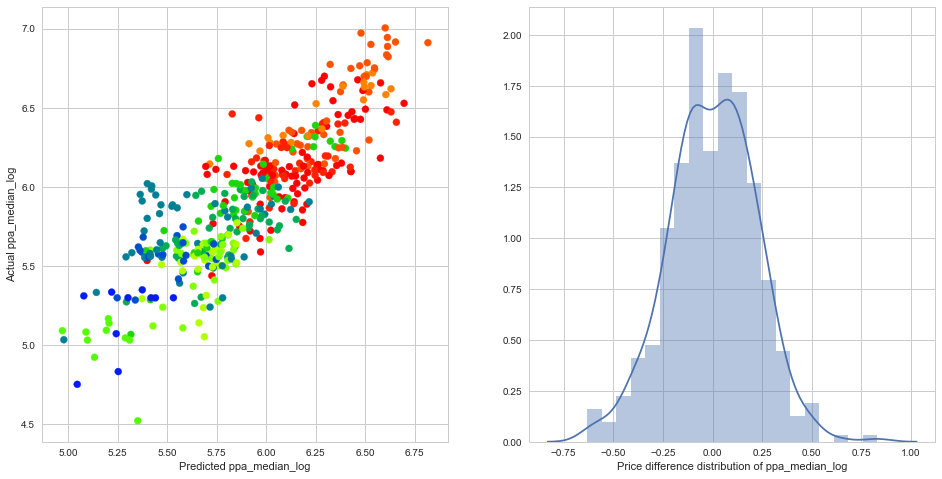

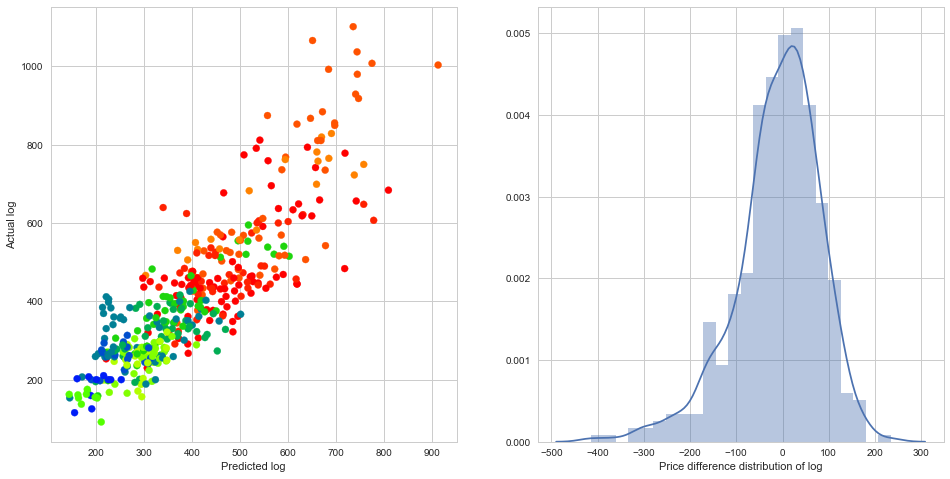

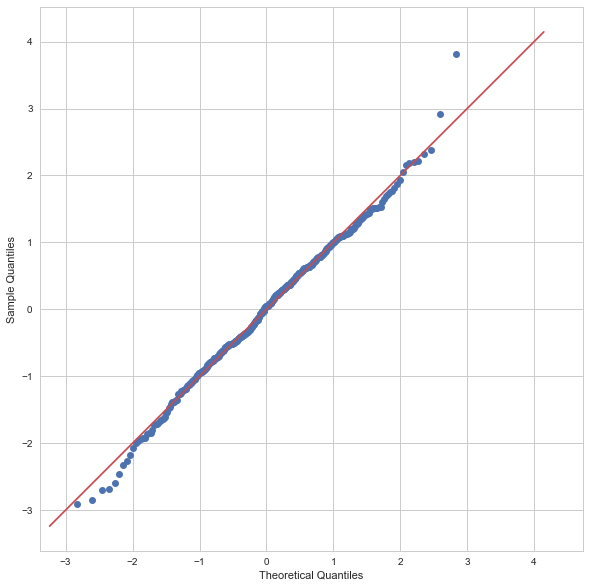

In [17]:
# print the fitted result for all area codes with label 1
print(df_cases.two.result.summary())
plot_results(df_cases.two, target)

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.two.result.predict(df_cases.two.dfX) - df_cases.two.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

In [18]:
target = 'ppa_median_log'
do_pca = True
do_f_reg = True
df_cases = Cases_df(df, target, do_pca, do_f_reg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     435.7
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:28:23   Log-Likelihood:                -73.905
No. Observations:                1210   AIC:                             169.8
Df Residuals:                    1199   BIC:                             225.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3823      0.007    724.590      0.0

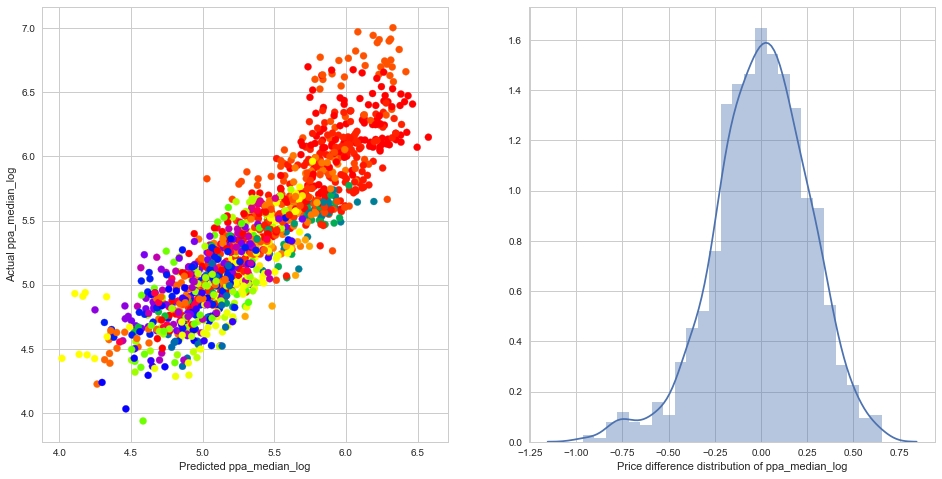

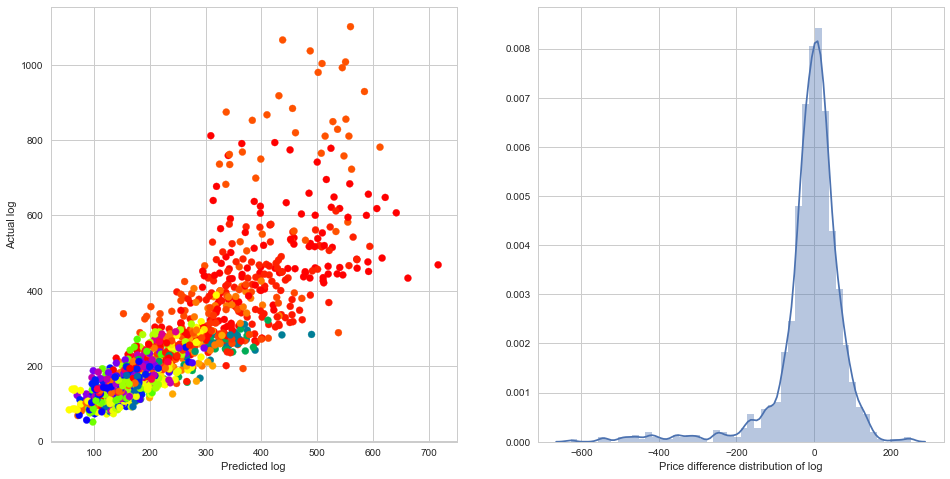

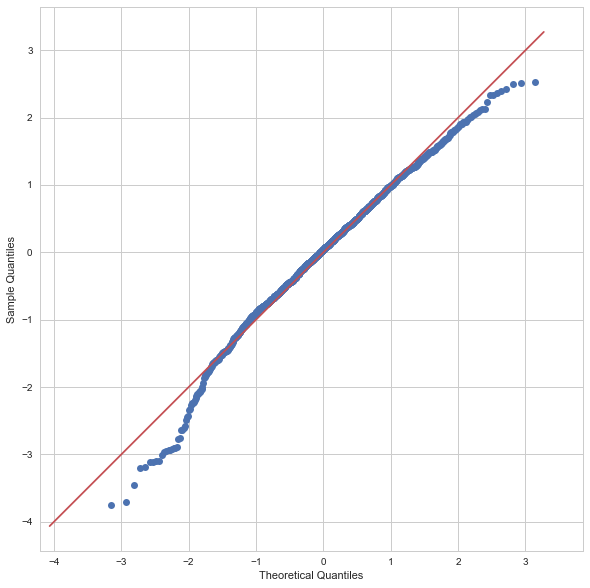

In [19]:
# print the fitted result for all area codes
print(df_cases.all.result.summary())
plot_results(df_cases.all, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.all.result.predict(df_cases.all.dfX) - df_cases.all.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     303.5
Date:                Fri, 21 Jul 2017   Prob (F-statistic):          2.25e-199
Time:                        19:28:24   Log-Likelihood:                 153.92
No. Observations:                 780   AIC:                            -293.8
Df Residuals:                     773   BIC:                            -261.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0881      0.007    712.172      0.0

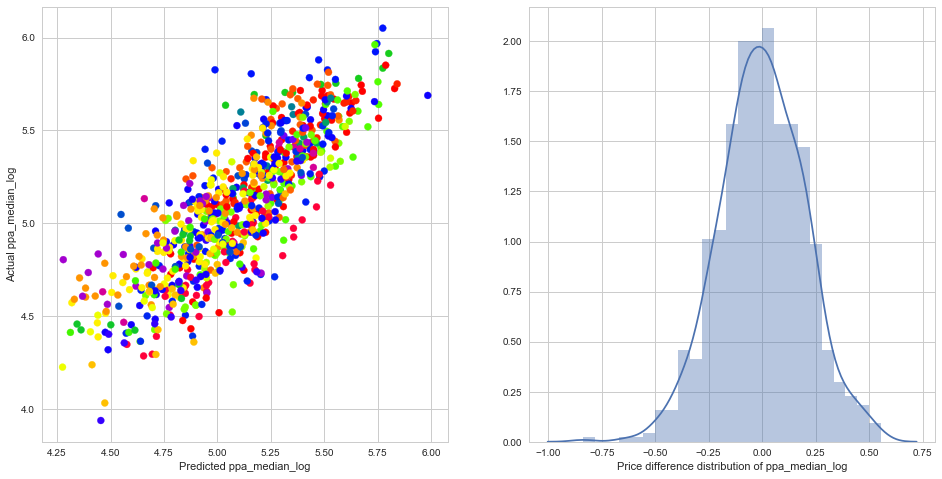

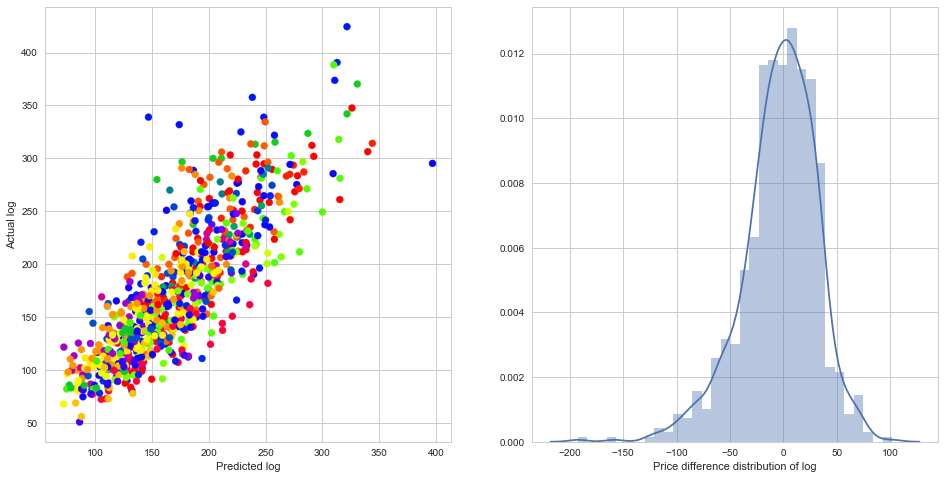

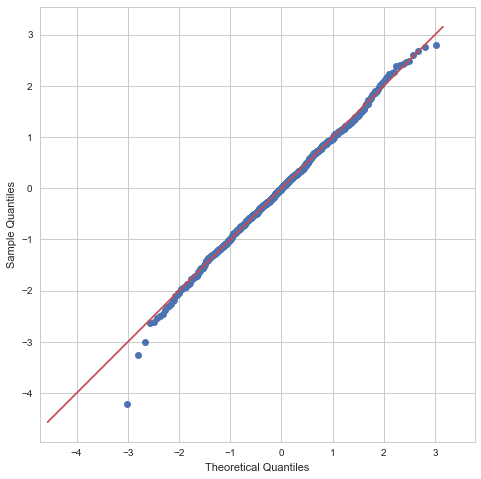

In [20]:
# print the fitted result for all area codes
print(df_cases.one.result.summary())
plot_results(df_cases.one, target)

# checking residual distribution normality
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.one.result.predict(df_cases.one.dfX) - df_cases.one.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     93.23
Date:                Fri, 21 Jul 2017   Prob (F-statistic):           2.67e-88
Time:                        19:28:25   Log-Likelihood:                -22.809
No. Observations:                 430   AIC:                             63.62
Df Residuals:                     421   BIC:                             100.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9161      0.012    475.749      0.0

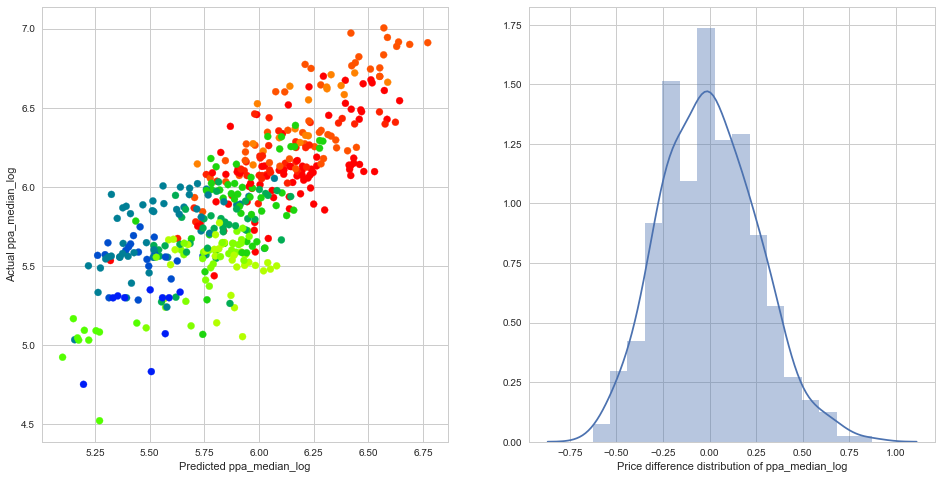

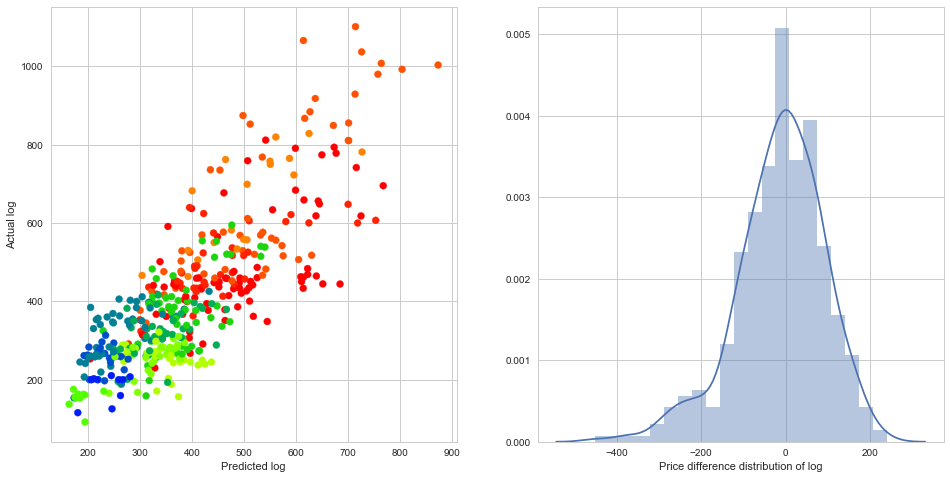

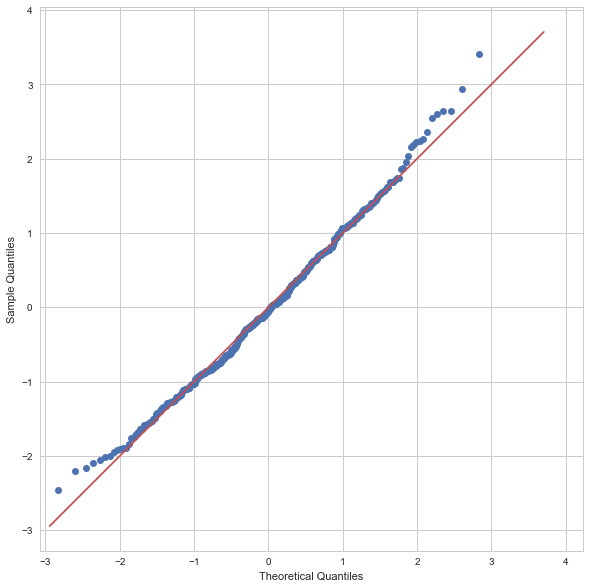

In [21]:
# print the fitted result for all area codes
print(df_cases.two.result.summary())
plot_results(df_cases.two, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.two.result.predict(df_cases.two.dfX) - df_cases.two.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");